In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [75]:
# 加载数据
train_data = pd.read_csv('train.csv', encoding='latin1')
test_data = pd.read_csv('test.csv', header=None, encoding='latin1')

# 将 "NR" 替换为 0，确保数据是数值类型
train_data.replace("NR", 0, inplace=True)
test_data.replace("NR", 0, inplace=True)


In [77]:
# 获取所有的污染物类型
pollutants = train_data.iloc[:, 2].unique()

# 创建一个字典保存每种污染物的数据
pollutant_data = {pollutant: [] for pollutant in pollutants}
pollutant_test_data = {pollutant: [] for pollutant in pollutants}

# 遍历数据集，将每种污染物的数据存储到对应的列表中
for pollutant in pollutants:
    pollutant_values = train_data[train_data.iloc[:, 2] == pollutant].iloc[:, 3:].values.flatten()
    pollutant_data[pollutant] = pollutant_values

    pollutant_values = test_data[test_data.iloc[:, 1] == pollutant].iloc[:, 2:].values.flatten()
    pollutant_test_data[pollutant] = pollutant_values

# 转换为18维向量形式
pollutant_vector = np.array([pollutant_data[pollutant] for pollutant in pollutants])
pollutant_test_vector = np.array([pollutant_test_data[pollutant] for pollutant in pollutants_test])

pollutant_vector.shape, pollutant_test_vector.shape, pollutants  # 展示向量的形状和污染物类型列表


((18, 5760),
 (18, 2160),
 array(['AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PM10',
        'PM2.5', 'RAINFALL', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC',
        'WIND_SPEED', 'WS_HR'], dtype=object))

In [79]:
# 提取 PM2.5 的数据，用于生成 train_y
pm25_data = pollutant_data['PM2.5']

# 初始化存储 train_x 和 train_y 的列表
train_x = []
train_y = []

# 每次取480笔数据，共12次
num_intervals = len(pm25_data) // 480

# 遍历每个480笔数据的区间
for interval in range(num_intervals):
    # 获取当前区间的数据起始和结束索引
    start_idx = interval * 480
    end_idx = start_idx + 480
    
    # 提取当前区间的PM2.5数据和污染物向量数据
    pm25_segment = pm25_data[start_idx:end_idx]
    pollutant_segment = pollutant_vector[:, start_idx:end_idx]
    
    # 在当前区间内滑动窗口生成特征和标签
    for i in range(len(pm25_segment) - 9):
        # 获取当前窗口的前9小时的数据，形状为 (18, 9) 然后展平为 (162,)
        x_sample = pollutant_segment[:, i:i+9].flatten()
        y_sample = pm25_segment[i + 9]  # 第10小时的 PM2.5 数据
        
        # 加入偏置项，在 x_sample 的开头添加一个常量1
        x_sample = np.insert(x_sample, 0, 1)
        
        # 将样本添加到列表中
        train_x.append(x_sample)
        train_y.append(y_sample)

# 转换为 numpy 数组
train_x = np.array(train_x, dtype=float)
train_y = np.array(train_y, dtype=float)

train_x.shape, train_y.shape  # 查看训练数据的形状


((5652, 163), (5652,))

In [80]:
# 初始化参数
weights = np.zeros(train_x.shape[1])
learning_rate = 0.01  # Adagrad 的初始学习率
iterations = 1000
prev_gra = np.zeros(train_x.shape[1])  # 用于存储梯度的累积和
cost_history_adagrad = []

# Adagrad 算法训练过程
for i in range(iterations):
    # 计算预测值 y'（train_x 和权重的内积）
    predictions = np.dot(train_x, weights)
    
    # 计算损失 (Loss = y' - train_y)
    loss = predictions - train_y
    
    # 计算平方差 (cost) 和标准差 (cost_a)
    cost = np.sum(loss ** 2) / len(train_x)
    cost_a = math.sqrt(cost)
    cost_history_adagrad.append(cost_a)
    
    # 计算梯度
    gradient = 2 * np.dot(train_x.T, loss)
    
    # 累积梯度平方和
    prev_gra += gradient ** 2
    
    # 计算调整后的学习率
    ada = np.sqrt(prev_gra)
    
    # 更新权重
    weights -= (learning_rate * gradient) / (ada + 1e-8)  # 添加一个小数以防除零

# 显示最终损失
cost_history_adagrad[-1]


7.328103395962335

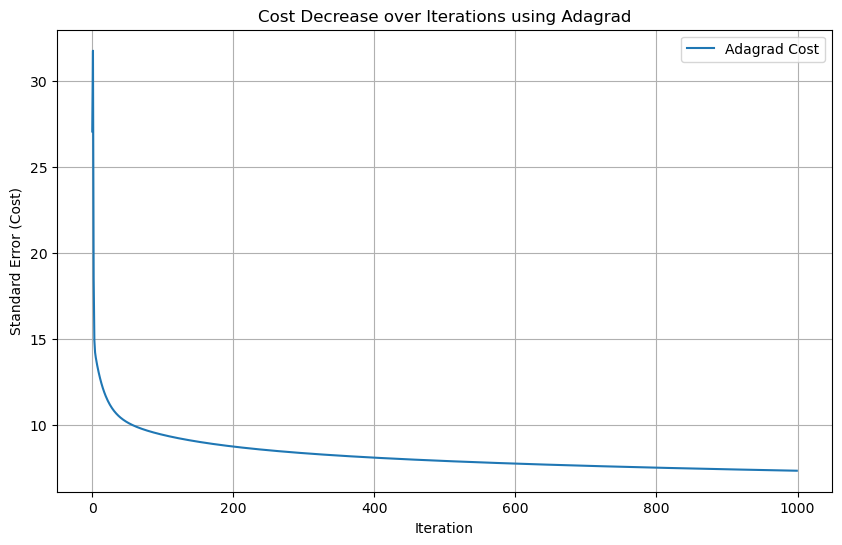

In [82]:
# 绘制损失下降曲线
plt.figure(figsize=(10, 6))
plt.plot(cost_history_adagrad, label='Adagrad Cost')
plt.xlabel('Iteration')
plt.ylabel('Standard Error (Cost)')
plt.title('Cost Decrease over Iterations using Adagrad')
plt.legend()
plt.grid(True)
plt.show()


In [85]:
# 保存模型
np.save('model_adagrad.npy', weights)

# 加载模型
loaded_weights = np.load('model_adagrad.npy')


In [87]:
# 构建测试集特征矩阵和目标值
test_x = []

#  pollutant_test_vector 是形状为 (18, N) 的二维数组
for i in range(0, pollutant_test_vector.shape[1], 9):
    # 获取当前窗口的前9小时的数据，形状为 (18, 9) 然后展平为 (162,)
    x_sample = pollutant_test_vector[:, i:i+9].flatten()
    
    # 加入偏置项，在 x_sample 的开头添加一个常量1
    x_sample = np.insert(x_sample, 0, 1)
    
    # 将样本添加到列表中
    test_x.append(x_sample)

# 转换为 numpy 数组
test_x = np.array(test_x, dtype=float)
print(test_x.shape)

# 使用训练好的模型进行预测
predictions_test = np.dot(test_x, loaded_weights)

# 生成评估结果文件
result = pd.DataFrame({
    "id": [f"id_{i}" for i in range(len(predictions_test))],
    "value": predictions_test
})
result.to_csv('prediction_results.csv', index=False)

print("预测结果已保存至文件 'prediction_results.csv'")


(240, 163)
预测结果已保存至文件 'prediction_results.csv'
